In [1]:
'''
DMRG module
'''

import jax.numpy as np
from jax.scipy.linalg import svd
from jax.numpy.linalg import qr
import jax
#import scipy.sparse.linalg.eigen.arpack as arp
key = jax.random.PRNGKey(0)
jax.config.update('jax_enable_x64', True)
##########################################################################################################
##### Random MPS #########################################################################################
##########################################################################################################


##### prelim funcs #######################################################################################

def chi_list(L,d,chi_max):
    '''Creates a list of the appropriate local bond dimensions in the d**i manner
    if chi_max > d**L/2:
    1 d d**2 .. d**L/2 .. d**2 d 1
    
    if chi_max < d**L/2:
    1 d d**2 .. chi_max chi_max chi_max .. d**2 d 1    
    '''
    a = np.ones(L+1,dtype=np.int_)
    for i in range(int(L/2)+1):
        val = d**i if d**i <= chi_max else chi_max
        a = a.at[i].set(val)
        a = a.at[-i-1].set(val) 
            
    return a

def create_random_Ms(L,d,chi_max):
    """
    returns a list of random MPS matrices (np_array(ndim=3))
    """
    chi = chi_list(L,d,chi_max)
    return [jax.random.uniform(key,shape=(chi[i],d,chi[i+1])) for i in range(L)]

##### Random MPS #########################################################################################

class random_MPS(object):
    """
    Initializes a random, finite dimensional, unnormalized MPS
    
    
    Parameters
    ------------
    L: Number of Sites
    d: local Hilbert space dimension (Schollwöck: sigma_j = 1,..,d)
    chi: local bond dimension (Schollwöch: DxD matrices)
    
    attributes:
    Ms: list of L ndim=3 tensors M with indices Ms[j]: sigma_j, vL, vR
    Ss: list of L ndim=1 lists with the Schmidt values
    L: number of sites
    chi: list of bond dimensions, -chi(i-1)--Ms[i]--chi(i)--Ms[i+1]--..
    normstat = None, 'left-norm', 'right-norm'
    
    """
    def __init__(self,L,d,chi_max):
        self.Ms = create_random_Ms(L,d,chi_max)
        self.Ss = [jax.random.uniform(key,shape=(L,d,chi_max)) for i in range(L)] # initially meaningless but may be updated after normalization
        self.L = L
        self.d = d
        self.chi_max = chi_max
        self.chi = chi_list(L,d,chi_max)
        self.normstat = None
        
    def get_Mi(self,i):
        return self.Ms[i]
    
    def self_norm(self):
        """calculate the norm of the MPS"""
        #C = 0
        #for j in range(self.d):
            #C += np.dot(self.Ms[0][j].transpose().conjugate(),self.Ms[0][j])
        C = np.tensordot(self.Ms[0].conjugate(),self.Ms[0],([0,1],[0,1])) # [1] {sl}  a'l, [1] {sl}  a'l
        for i in range(1,self.L):
            # sum over physical sites 1 .. L
            for j in range(self.d):
                # sum over physical index s_i = 1 .. d
                """
                M1: sl al a'l
                M2: sl al a'l

                """
                temp1 = np.tensordot(C,self.Ms[i],[1,0]) #al [a'l], [al] sl  a'l
                C2 = np.tensordot(self.Ms[i].conj(),temp1,([0,1],[0,1])) # (T) [al] {sl} a'l , [al] {sl} a'l
            C = C2
        return C[0,0]

    def right_normalize(self,test=False):
        """
        returns a right_normalized version of the random_MPS() object
        
        new version using QR
        """
        #Pseudo Code
        #get M[L]
        #reshape M[L] to Psi
        #SVD of PSI
        #reshape V^h to B[L], save S[L], multiply M[L-1] U S = Mt[L-1]
        #repeat procedure
        Ms = self.Ms
        L,d,chi = self.L,self.d,self.chi
        Bs = []
        for i in range(L-1,-1,-1):
            chi1,d,chi2 = Ms[i].shape # a_i-1, sigma_i, s_i
            m = Ms[i].reshape(chi1,d*chi2)
            Q,R = qr(m.conjugate().transpose(), mode='reduced') #in numpy.linalg.qr 'reduced' is standard whilst not in scipy version
            B = Q.conjugate().transpose().reshape(min(m.shape),d,chi2) #  s_i-1, sigma_i , s_i
            Bs.append(B)
            # problem gefunden, ich speicher ja nirgends B ab
            
            # update next M matrix to M-tilde = M U S
            # in order not to overwrite the first matrix again when hitting i=0 use
            if i>0: 
                Ms[i-1] = np.tensordot(Ms[i-1],R.conjugate().transpose(),1) #  a_L-2 sigma_L-1 [a_L-1] , [a_L-1] s_L-1
            if test:
                # check if right-normalization is fulfilled, should give identity matrices
                print(np.real_if_close(np.tensordot(B,B.conjugate(),axes=([2,1],[2,1])))) # s_i-1 [sigma]  [a_i], s_i-1 [sigma] [a_i]
        #return Ms
        # or update
        self.Ms = Bs[::-1]
        self.normstat = 'right-norm'
        
    def left_normalize(self,test=False):
        """
        returns a left_normalized version of the random_MPS() object using QR
        """
        #Pseudo Code
        #get M[L]
        #reshape M[L] to Psi
        #SVD of PSI
        #reshape V^h to B[L], save S[L], multiply M[L-1] U S = Mt[L-1]
        #repeat procedure
        Ms = self.Ms
        L,d = self.L,self.d
        As = []
        for i in range(L):
            chi1,d,chi2 = Ms[i].shape # a_i-1, sigma_i, s_i
            m = Ms[i].reshape(chi1*d,chi2)
            Q,R = qr(m, mode='reduced') #in numpy.linalg.qr 'reduced' is standard whilst not in scipy version
            A = Q.reshape(chi1,d,min(m.shape)) #  a_i-1, sigma_i , s_i
            As.append(A)
            # problem gefunden, ich speicher ja nirgends B ab
            
            # update next M matrix to M-tilde = M U S
            # in order not to overwrite the first matrix again when hitting i=0 use
            if i<(L-2): 
                Ms[i+1] = np.tensordot(R,Ms[i+1],1) #s_i [a_i], [a_i] s_i+1 a_i+1
            if test:
                # check if right-normalization is fulfilled, should give identity matrices
                print(np.real_if_close(np.tensordot(A.conjugate(),A,axes=([0,1],[0,1])))) # [s_i-1] [sigma]  a_i, [s_i-1] [sigma] a_i
        #return Ms
        # or update
        self.Ms = As
        self.normstat = 'left-norm'

##########################################################################################################
##### Ising MPO ##########################################################################################
##########################################################################################################


class Ising_MPO(object):
    '''
    Transverse Ising field Hamiltonian
    H = -J \\sum_i \sigma_i^x \sigma_{i+1}^x - h \\sum_i \sigma_i^z
    '''
    def __init__(self, L, d, h, J):
        self.L = L
        self.d = d
        self.h = h
        self.J = J

        self.sx = np.array([[0., 1.], [1., 0.]])
        self.sz = np.array([[1., 0.], [0., -1.]])
        self.id = np.eye(2)
        self.Ws = self.init_W()  # [?] in toycode they do this a bit strange
                                 # and make the definition self.W inside init_W, is this necessary or rather 'style'?
    
    def init_W(self):
        # Create the matrix of operators (2x2 matrices)
        # (virtual left, virtual right, physical out, physical in)
        # vL, vR, s, s'
        Ws = []
        
        # First vector Ws[0] = [1 , X , -g Z]
        w = np.zeros((1, 3, self.d, self.d), dtype=complex)
        w = w.at[0, 0].set(self.id)
        w = w.at[0, 1].set(self.sx)
        w = w.at[0, 2].set(-self.h * self.sz)
        Ws.append(w)
        
        # W[i] matrix
        w = np.zeros((3, 3, self.d, self.d), dtype=complex)
        # top row: 1 X -g Z
        w = w.at[0, 0].set(self.id)
        w = w.at[0, 1].set(self.sx)
        w = w.at[0, 2].set(-self.h * self.sz)
        # right column (-g Z , -J X ,1)^T
        w = w.at[1, 2].set(-self.J * self.sx)
        w = w.at[2, 2].set(self.id)
        
        # create L-2 times the same matrix
        for i in range(1, self.L-1):
            Ws.append(w)
        
        # Last vector W[L-1]^T = [-g Z, -J X, 1]^T
        w = np.zeros((3, 1, self.d, self.d), dtype=complex)
        w = w.at[0, 0].set(-self.h * self.sz)
        w = w.at[1, 0].set(-self.J * self.sx)
        w = w.at[2, 0].set(self.id)
        Ws.append(w)
        
        return Ws

class Pauli_MPO(object):
    '''
    Transverse Ising field Hamiltonian
    H = -J \\sum_i \sigma_i^x \sigma_{i+1}^x - h \\sum_i \sigma_i^z
    '''
    def __init__(self, L, d, pauli_string):
        self.L = L
        self.pauli_string = pauli_string
        self.d = d

        self.sx = np.array([[0., 1.], [1., 0.]])
        self.sy = np.array([[0., -1j], [1j, 0.]])
        self.sz = np.array([[1., 0.], [0., -1.]])
        self.id = np.eye(2)
        self.Ws = self.init_W()  # [?] in toycode they do this a bit strange
                                 # and make the definition self.W inside init_W, is this necessary or rather 'style'?
    
    def init_W(self):
        # Create the matrix of operators (2x2 matrices)
        # (virtual left, virtual right, physical out, physical in)
        # vL, vR, s, s'
        Ws = []

        for i in range(0, self.L):
            w = np.zeros((1, 1, 2, 2), dtype=complex)
            if self.pauli_string[i] == '0': 
                w = w.at[0, 0].set(self.id)
            elif self.pauli_string[i] == '1': 
                w = w.at[0, 0].set(self.sx)
            elif self.pauli_string[i] == '2': 
                w = w.at[0, 0].set(self.sy)
            elif self.pauli_string[i] == '3': 
                w = w.at[0, 0].set(self.sz)
            Ws.append(w)
        
        # Last vector W[L-1]^T = [-g Z, -J X, 1]^T

        Ws.append(w)
        
        return Ws
##########################################################################################################
##### DMRG ENGINE ########################################################################################
##########################################################################################################

class DMRG(object):
    '''
    Abstract DMRG engine class
    
    attributes:
    MPS*: the current MPS
    MPO: the model MPO
    RPs*: the current RPs
    LPs*: the current LPs
    (*): get regular updates
    
    LPs[i] is LP left site i, i.e. LPs[0] is dummy and LPs[-1] = LPs[L-1] is everything but the last
    RPs[i] is RP right of site i, i.e. RPs[-1]=RPs[L-1] is dummy and RPs[0] is everything but the first
    
    Parameters:
    MPS: object, matrix product state
    MPO: object, matrix product operator
    eps: float, epsilon determining the threshold of which singular values to keep, standard set to 10^-10
    chi_max: int, maximal bond dimension of system
    test: for debugging, prints things like Ms.shape, norm, singular values etc. during sweep
    
    
    '''
    def __init__(self,MPS,MPO,eps=1e-10,chi_max=None,test=False):
        self.test = test
        # initial MPS, ensure that it is right-normalized
        MPS.right_normalize()
        self.MPS = MPS 
        #self.Ms = self.MPS.Ms
        self.MPO = MPO
        self.L = self.MPS.L
        self.eps = eps
        if chi_max is None:
            self.chi_max = self.MPS.Ms[0].shape[1]**self.L # Standard full value chi_max = d^L
        else:
            self.chi_max = chi_max
            
        # Eigen energy from site_update(i):
        self.e = []
        
        ### initialize right- and left parts
        # create empty list of correct size
        self.LPs = [None] * self.L
        self.RPs = [None] * self.L
        # LP can stay empty except for dummy one
        self.LPs[0] = np.ones((1,1,1))
        self.RPs[-1] = np.ones((1,1,1))
        # starting from a left to right need to initialize all the RPs once
        for i in range(self.L - 1,0,-1):
            # from L-1 to 1
            self.RPs[i-1] = self.next_RP(i)
        
    def site_update(self,i):
        '''
        Solves the Eigenvalue problem H_eff v = E v
        
        Returns updated matrix M
        '''
        # Pseudo code
        # get Heff[i]
        LP = self.LPs[i]
        RP = self.RPs[i]
        W = self.MPO.Ws[i]
        heff = H_eff(LP,RP,W)
        heffmat = heff.Heff_mat
        Mshape_ = self.MPS.Ms[i].shape
        #vguess = self.MPS.Ms[i].reshape(np.prod(Mshape_))
        vguess = self.MPS.Ms[i].reshape(np.prod(np.array(Mshape_)))

        # solve Eigenproblem
        ### this is stolen from d_dmrg.py in TeNPy/toycodes
        #e, v = arp.eigsh(heffmat, k=1, which='SA', return_eigenvectors=True, v0=vguess)
        e, v = np.linalg.eigh(heffmat)
        #print(e)
        #energy = evals[0]
        #psi0 = eigvecs[:, 0]
        if self.test:
            print('Eigenvalue e: ',e[0])
        # collect these e even though test may be False
        self.e.append(e[0])
        # returns v as a column dim=(d,1) vector instead of a list dim(d,)
        v = v[:,0]
        # return updated M
        M = v.reshape(Mshape_)
        return M , e[0]
    
    def left_to_right(self,eps=None,chi_max=None):
        '''
        Runs through the MPS from left to right
        '''
        # use attribute of class as standard parameter
        if eps is None:
            eps = self.eps
        if chi_max is None:
            chi_max = self.chi_max
        
        # Pseudo code
        # start from right-normalized state BBBB..
        assert self.MPS.normstat == 'right-norm'
        if self.test:
            print('the initial norm is', self.MPS.self_norm())
        
        # update site to new M: MBBB..
        # left_normalize to ABBB..
        # update LP and RP
        # repeat? -> AMBB -> AABB repeat -> AAMB -> AAAB
        for i in range(self.L):
            ### ..AA[M]BB..
            M = self.MPS.Ms[i]
            # update to new M
            M,e = self.site_update(i)
            ### ..AA[M']BB..
            # left_normalize to A
            A,S,V = left_norm(M,eps,test=self.test)
            # update Ms
            self.MPS.Ms[i] = A
            ### ..AA[A]SVBB..
            if self.test:
                print('A at site',i,' has shape ', A.shape)
            
            if i < self.L - 1:
                # update the following M in line accordingly
                ### ..AA[A](B'=SVB)B..
                SV = np.tensordot(np.diag(S),V,1) # ss_i (ss_i) , (ss_i) s_i a_i+1
                self.MPS.Ms[i+1] = np.tensordot(SV,self.MPS.Ms[i+1],1) # ss_i s_i (a_i+1) , (a_i+1) s_i+1 a_i+2
                
                if self.test:
                    # for testing print norm of state
                    print('norm(MPS) ', self.MPS.self_norm())
                
                # update LP
                ### LPs[0] = dummy, LPs[1] = up to site 0, LPs[2] = up to site 1
                self.LPs[i+1] = self.next_LP(i) # i=0 is dummy, i=L-1 is all but the last / everything left of the last site L-1
        # update norm status of MPO
        self.MPS.normstat = 'left-norm'

    def right_to_left(self,eps=None,chi_max=None):
        '''
        Runs through the MPS from right to left
        '''
        # use attribute of class as standard parameter
        if eps is None:
            eps = self.eps
        if chi_max is None:
            chi_max = self.chi_max
        
        # Pseudo code
        # start from left-normalized state AAAA..
        assert self.MPS.normstat == 'left-norm'
        # from left-to-right state is already in left-normal form
        if self.test:
            print('the initial norm is', self.MPS.self_norm())
        # i = 1,..,L
        for i in range(1,self.L + 1):
            ### ..AA[M]BB..
            M = self.MPS.Ms[-i]
            # update to new M
            M,e = self.site_update(-i)
            ### ..AA[M']BB..
            # right_normalize to B
            U,S,B = right_norm(M,eps,test=self.test)
            # update Ms
            self.MPS.Ms[-i] = B
            ### ..AA[A]SVBB..
            if self.test:
                print('A at site',-i,' has shape ', B.shape)
            
            # Ms[-L] = Ms[0], stop updating the following (to the left) at -L+1
            if i < self.L:
                # update the following M in line accordingly
                ### ..AA[A](B'=SVB)B..
                US = np.tensordot(U,np.diag(S),1) # ss_i (ss_i) , (ss_i) s_i a_i+1
                self.MPS.Ms[-i-1] = np.tensordot(self.MPS.Ms[-i-1],US,1) # ss_i s_i (a_i+1) , (a_i+1) s_i+1 a_i+2
                
                if self.test:
                    # for testing print norm of state
                    print('norm(MPS) ', self.MPS.self_norm())
                
                # update LP
                ### LPs[0] = dummy, LPs[1] = up to site 0, LPs[2] = up to site 1
                self.RPs[-i-1] = self.next_RP(-i) # i=0 is dummy, i=L-1 is all but the last / everything left of the last site L-1
        # update normstat
        self.MPS.normstat = 'right-norm'
    
    def next_LP(self,i):
        '''
        short version: LP[i] |-> LP[i+1] # Remember: LP[i] inlcudes everythings EXCEPT i -> need to add the contributions at site i
        
        extend LP from site i to the next site i+1 
        .------a_j-1----M[j]--a_j
         |               |
        LP[j]--b_j-1----W[j]--b_j
         |               |
        .-----a'_j-1---M*[j]--a'_j
        
        next_LP(i): takes LPs[i] and contracts with the (right-) following M[i] ,W[i] and M*[i]

        result: np.array[ndim=3] # a_i b_i  a'_i
        '''
        F = self.LPs[i]

        F = np.tensordot(F,self.MPS.Ms[i],axes=[2,0]) # a_i-1 b_i-1 [a'_i-1] , [a_i-1] s_i a'_i
        F = np.tensordot(self.MPO.Ws[i],F,axes=([2,0],[2,1])) # [b_i-1] b_i [s_i] s'_i , a_i-1 [b_i-1] [s_i] a'_i
        F = np.tensordot(self.MPS.Ms[i].conj(),F,axes=([0,1],[2,1])) # [a_i-1] [s_i] a_i , b_i [s'_i] [a_i-1] a'_i
        # result is F with indices a_i b_i  a'_i
        return F
    
    def next_RP(self,i):
        '''
        short version: RP[i] |-> RP[i-1]
        
        extend LP from site i to the next site i+1 
        --a_j-1----M*[j]--a_j----.
                   |            |
        --b_j-1----W[j]--b_j---RP[j]
                   |            |
        --a'_j-1---M[j]--a'_j--.
        
        next_LP(i): takes RPs[i] and contracts with the (left-)following M[i] ,W[i] and M*[i]

        result: np.array[ndim=3] # a_i b_i  a'_i
        '''
        F = self.RPs[i]
        
        F = np.tensordot(self.MPS.Ms[i],F,axes=([2],[2])) # a'_i-1 s'_i [a'_i] , a_i b_i [a'_i]
        F = np.tensordot(self.MPO.Ws[i],F,axes=([3,1],[1,3])) # b_i-1 [b_i] s_i [s'_i] , a'_i-1 [s'_i] a_i [b_i]
        F = np.tensordot(self.MPS.Ms[i].conj(),F,axes=([1,2],[1,3])) # a_i-1 [s_i] [a_i] , b_i-1 [s_i] a'_i-1 [a_i]
        # result is F with indices a_i-1 b_i-1  a'_i-1
        return F
    
##### left_norm ##############################################################################################

def left_norm(M,eps,chi_max=None,test=False):
    '''
    left_norm is written for DMRG engine class (concerning the parameters)
    
    SVD + compression of site for left-normalizing (going left-to-right)
    
    input::
    Matrix at site i
    eps: tolerance on what is counted as 0
    chi_max: max bond dimensions
    
    output::
    newM, St, Vht: new matrix M, truncated sing. vals, St, trancated Vht
    
    '''
    # Reshape M to Psi
    chiL, d, chiR = M.shape
    Psi = M.reshape(chiL*d,chiR)
    # do SVD
    U,S,Vh = svd(Psi,full_matrices=False) # automatically takes care of the ordering
    if test:
        # print singular values at each step 
        print('S (full)', S)
    # check for singular values > 0 (or in reality: > epsilon )
    nonzeros = S>eps
    # take only the ones != 0
    if chi_max is None:
        chi_max = min(chiL*d,chiR)
    newchi = min(chi_max,np.sum(nonzeros)) # summing over True / False = counting True's
    if test:
        print('sum(nonzeros): ', np.sum(nonzeros))
        print('chi_max: ', chi_max)
        print('newchi: ', newchi)
    if newchi == 0:
        newchi = 1
        #nonzeros = [True]
    #else:
        #nonzeros = nonzeros[:newchi]
    
    # leave only the ones up to chi_max

    Ut, St, Vht = U[:,:newchi],S[:newchi],Vh[:newchi,:]
    # renormalize
    St = St * np.linalg.norm(St)**(-1)
    if test:
        print('truncated St ', St)
        print('U^+ U = ', np.dot(Ut.transpose().conj(),Ut))
    # reshape + return U and Vh
    newM = Ut.reshape(chiL,d,newchi)
    return newM,St,Vht

##### right_norm ##############################################################################################

def right_norm(M,eps,chi_max=None,test=False):
    '''
    left_norm is written for DMRG engine class (concerning the parameters)
    
    SVD + compression of site for right-normalizing (going right-to-left)
    
    input::
    Matrix at site i
    eps: tolerance on what is counted as 0
    chi_max: max bond dimensions
    
    output::
    Ut, St, newM: new matrix M, truncated sing. vals, St, trancated Uht
    
    '''
    # Reshape M to Psi
    chiL, d, chiR = M.shape
    Psi = M.reshape(chiL,chiR*d)
    # do SVD
    U,S,Vh = svd(Psi,full_matrices=False) # automatically takes care of the ordering
    if test:
        # print singular values at each step 
        print('S (full)', S)
    # check for singular values > 0 (or in reality: > epsilon )
    nonzeros = S>eps
    # take only the ones != 0
    if chi_max is None:
        chi_max = min(chiL,chiR*d)
    newchi = min(chi_max,np.sum(nonzeros)) # summing over True / False = counting True's
    if test:
        print('sum(nonzeros): ', np.sum(nonzeros))
        print('chi_max: ', chi_max)
        print('newchi: ', newchi)
    if newchi == 0:
        newchi = 1
        #nonzeros = [True]
    #else:
        #nonzeros = nonzeros[:newchi]
    
    # leave only the ones up to chi_max

    Ut, St, Vht = U[:,:newchi],S[:newchi],Vh[:newchi,:]
    # renormalize
    St = St * np.linalg.norm(St)**(-1)
    if test:
        print('truncated St ', St)
        print('U^+ U = ', np.dot(Ut.transpose().conj(),Ut))
    # reshape + return U and Vh
    newM = Vht.reshape(newchi,d,chiR)
    return Ut,St,newM

##### H_eff ##################################################################################################

class H_eff(object):
    '''
    effective Hamiltonian of the contracted right- and left part
    .--a_l-1       a_l--.
    |         s_l       |
    |          |        |
    LP--b_l-1--W--b_l--RP
    |          |        |
    |         s'_l      |
    .--a'_l       a'_l--.
    
    LP[a_l-1,b_l-1,a'_l-1]   # dim [chiL1, chiLw chiLd]
    RP[a_l,b_l,a'_l]         # dim [chiR1,chiRw,chiRd]
    
    W[b_l-1, b_l, s_l, s'_l] # dim [chiLw, chiRw, d, dd]
    
    H[(a_l-1, s_l, a_l),(a'_l-1, s'_l, a'_l)] (matrix to be diagonalized)
    '''
    def __init__(self,LP,RP,W):
        self.RP = RP
        self.LP = LP
        self.W = W
        chiL1,chiLw,chiLd = LP.shape #chiLd = chiL1 redundant
        chiR1,chiRw,chiRd = RP.shape # chiRd = chiR1 redundant
        chiLw, chiRw, d, dd = W.shape # double definition chiLw chiRw redundant but for overview
        self.Heff = self.init_Heff()  # [a_l-1, s_l, a_l, a'_l-1, s'_l, a'_l]
        self.Heff_mat = self.Heff.reshape(chiL1*chiR1*d, dd*chiL1*chiR1)
    
    def init_Heff(self):
        '''return the ndim=6 tensor that is H_eff[a_l-1,a'_l-1, s_l, s'_l, a_l,a'_l]
        '''
        temp = np.tensordot(self.W,self.RP,axes=([1],[1])) # [b_l-1, (b_l), s_l, s'_l] ; [a_l,(b_l),a'_l]
        temp = np.tensordot(self.LP,temp,axes=([1],[0])) # [a_l-1,(b_l-1),a'_l-1] ; [(b_l-1), s_l, s'_l, a_l,a'_l]
        # has indeces:  [a_l-1, a'_l-1, s_l, s'_l, a_l, a'_l]
        # want indices: [a_l-1, s_l, a_l, a'_l-1, s'_l, a'_l]
        # permutation [0,2,4,1,3,5]
        return np.transpose(temp,(0,2,4,1,3,5))

##### <Psi | MPO | Psi> ##############################################################################################
    
def expect_mpo(state,MPO):
    '''
    Full contraction over the whole <MPS|MPO|MPS>
    
    it is basically creating the left part iteratively over the whole MPS
    .--------a_j-1   -M[j]---
     |                  |
    LP[j-1]--b_j-1   -W[j] etc.
     |                  |
    .--------a'_j-1  -M[j]---
    '''
    assert state.L == MPO.L
    assert state.d == MPO.d
    # Pseudo code
    # get list of matrices from state
    # get list of matrices from MPO
    # iteratively calculate F[i], the 3-legged tensor to build up the left side
    Ms = state.Ms
    Ws = MPO.Ws
    # initial dummy F = 1
    F = np.ones((1,1,1),dtype=complex)
    # i = 0 1 2 .. j-1
    for i in range(state.L):
        F = np.tensordot(F,Ms[i],axes=[2,0]) # a_i-1 b_i-1 [a'_i-1] , [a_i-1] s_i a'_i
        F = np.tensordot(Ws[i],F,axes=([2,0],[2,1])) # [b_i-1] b_i [s_i] s'_i , a_i-1 [b_i-1] [s_i] a'_i
        F = np.tensordot(Ms[i].conj(),F,axes=([0,1],[2,1])) # [a_i-1] [s_i] a_i , b_i [s'_i] [a_i-1] a'_i
        # result is F with indices a_i b_i  a'_i
    return np.real(F)[0,0,0] if np.all(np.isclose(np.real(F), 0)) else F[0,0,0]


In [2]:
sxx = np.array([[0., 1.], [1., 0.]])
syy = np.array([[0., -1j], [1j, 0.]])
szz = np.array([[1., 0.], [0., -1.]])

In [3]:
def dmrg_E(L,J,g,conf=1e-4,test=False,chi_max=10, max_sweep = 5):
    # Initialize random MPS and MPO
    # chi_max: max bond dimension - b/c we are using jax, we are limited to relatively small chi; 
    # setting to 10 for now
    init_mps = random_MPS(L=L,d=2,chi_max=chi_max)
    mpo = Ising_MPO(L=L,d=2,h=g,J=J)
    dmrg = DMRG(init_mps,mpo,eps=-1.,chi_max=chi_max,test=False)
    
    diff = 5.*conf
    counter = 0
    while diff > conf:
        if test:
            print(counter)
        counter += 1
        ### note: we could also simply use the current dmrg.e value to speed things up. This is just to give justification to the expect_mpo(mps,mpo) function
        e_in = expect_mpo(dmrg.MPS,mpo)
        dmrg.left_to_right()
        dmrg.right_to_left()
        e_end = expect_mpo(dmrg.MPS,mpo)
        diff = abs(e_in - e_end)
        print(f'sweep: {counter}, E: {dmrg.e[-1]}')
        if counter > max_sweep:
            break
    return dmrg.MPS, dmrg.e[-1]



In [4]:
L = 100
mps, E = dmrg_E(L=L,g=1,J=1.)

sweep: 1, E: -126.95892159724117
sweep: 2, E: -126.9618601647224
sweep: 3, E: -126.96186162119784


In [5]:
E

Array(-126.96186162, dtype=float64)

In [6]:
# Now, given the MPS, calculate the Pauli expectations
# pauli_string: 0,1,2,3 for I, X, Y, Z
# for example: 3000.., means ZIII...
Sz_list= []
for i in range (100):
    mpo = Pauli_MPO(L=L,d = 2,pauli_string = '0'*(i)+'3'+'0'*(L-i-1))
    Sz_list.append(expect_mpo(mps,mpo))

Text(0, 0.5, 'Sz')

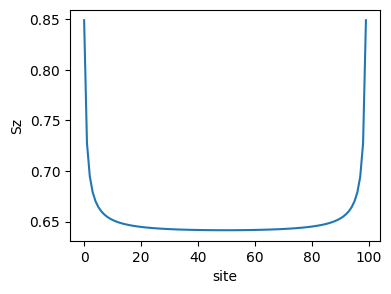

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize = (4,3))
plt.plot(Sz_list)
plt.xlabel('site')
plt.ylabel('Sz')